In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer



# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [63]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df.sample(10)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
160,24/11/2020 12:17:21,34.0,Male,Vienna,Data Scientist,12,3,Senior,NaN,"Python, SQL, AWS, Azure",77500.0,7750,25,Full-time employee,Unlimited contract,English,101-1000,Consulting / Agency
899,29/11/2020 01:29:24,35.0,Male,Berlin,Frontend Developer,6,1,Middle,React / JavaScript,Javascript / Typescript,66500.0,NaN,27,Full-time employee,Unlimited contract,English,1000+,Product
11,24/11/2020 11:18:16,NaN,Male,Berlin,Software Engineer,25,11,Senior,C++,"Python, C/C++, SQL",100000.0,101,24,Self-employed (freelancer),Temporary contract,English,11-50,Product
1251,19/01/2021 10:17:58,26.0,Male,Saarbrücken,Frontend Developer,7,7,Middle,JavaScript,"Javascript / Typescript, Docker, HTML, CSS; Ad...",38350.0,40950,27,Full-time employee,Unlimited contract,German,101-1000,Product
739,26/11/2020 08:46:32,42.0,Female,Berlin,QA Engineer,10,3,Middle,"JS, WDIO","Javascript / Typescript, SQL, Docker",42000.0,0,NaN,Full-time employee,Unlimited contract,English,11-50,Startup
198,24/11/2020 12:55:58,35.0,Female,Berlin,Software Engineer,15,6,Senior,C#,.NET,76000.0,NaN,30,Full-time employee,Unlimited contract,German,1000+,Product
797,26/11/2020 21:30:58,30.0,Male,Berlin,QA Engineer,8,3,Senior,Python,"Python, C/C++, Docker",68000.0,NaN,30,Full-time employee,Unlimited contract,English,51-100,Startup
245,24/11/2020 14:06:46,30.0,Female,Frankfurt,QA Engineer,6,4,Senior,Bash,"Python, Java / Scala, SQL, AWS, Azure",70000.0,2000,30,Full-time employee,Unlimited contract,German,1000+,Bank
652,25/11/2020 17:46:23,34.0,Female,Berlin,NaN,13,3,Principal,python,"AWS, Terraform, Scala Spark,",108000.0,NaN,28,Full-time employee,Unlimited contract,English,1000+,Product
729,26/11/2020 07:06:11,33.0,Male,Munich,Software Engineer,11,6,Senior,JavaScript,".NET, SQL",80000.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product


In [65]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [66]:
df.head()

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,30,Full-time employee,Unlimited contract,English,51-100,Product
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product
3,24/11/2020 11:15:24,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,54000.0,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup
4,24/11/2020 11:15:46,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",62000.0,NaN,29,Full-time employee,Unlimited contract,English,101-1000,Product


In [ ]:
# Remove the rows with missing values
df.dropna(inplace=True)

# Remove the duplicates
df.drop_duplicates(inplace=True)

# Replace the invalid values with a meaningful representation
df.replace(-999, 0, inplace=True)

# Convert the data type of a column to a specific type
df["column_name"] = pd.to_numeric(df["column_name"], downcast="float", errors="coerce")
df["column_name"].fillna(0, inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

# Save the cleaned data to a new file
df.to_csv("cleaned_data.csv", index=False)

In [67]:
# Construct Target by adding salary and bonus. 
df["Bonus"] = pd.to_numeric(df["Yearly bonus + stocks in EUR"], downcast="float", errors="coerce")
df["Bonus"].fillna(0, inplace=True)
df["target"] = df["Yearly brutto salary (without bonus and stocks) in EUR"] + df["Bonus"]
df.drop(columns={"Timestamp","Yearly brutto salary (without bonus and stocks) in EUR", "Yearly bonus + stocks in EUR", "Bonus"}, inplace=True)
df.head()

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,target
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",30,Full-time employee,Unlimited contract,English,51-100,Product,85000.0
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,28,Full-time employee,Unlimited contract,English,101-1000,Product,80000.0
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,240000.0
3,28.0,Male,Berlin,Frontend Developer,4,1,Junior,Javascript,NaN,24,Full-time employee,Unlimited contract,English,51-100,Startup,54000.0
4,37.0,Male,Berlin,Backend Developer,17,6,Senior,C# .NET,".NET, SQL, AWS, Docker",29,Full-time employee,Unlimited contract,English,101-1000,Product,62000.0


In [68]:
# Use the 'target' column as the target variable
y = df["target"]
# Drop the target variable from the DataFrame
df.drop(["target"], axis=1, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Create a pipeline for the data processing and model fitting
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['Age']),
        ('cat', OneHotEncoder(), ['Gender'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Transform the training and testing data
X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)


array([[0.40816327, 0.        , 0.        , 0.        , 1.        ],
       [0.2244898 , 0.        , 1.        , 0.        , 0.        ],
       [0.32653061, 0.        , 0.        , 1.        , 0.        ],
       ...,
       [0.26530612, 0.        , 0.        , 1.        , 0.        ],
       [0.26530612, 0.        , 0.        , 1.        , 0.        ],
       [0.20408163, 0.        , 0.        , 1.        , 0.        ]])

In [69]:
# Create the Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to the processed training data
regressor.fit(X_train_processed, y_train)

# Make predictions on the processed testing data
y_pred = regressor.predict(X_test_processed)

In [71]:
#Evaluate the performance of the model by computing its mean absolute error, mean squared error, and root mean squared error:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Absolute Error:  292651209.1982118
Mean Squared Error:  5.373029574307305e+18
Root Mean Squared Error:  2317979631.987155
R2 Score:  -904170977.1215978


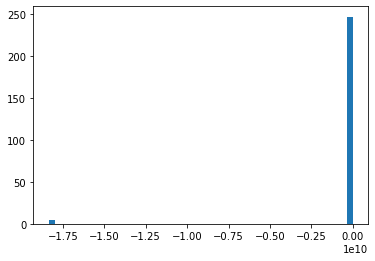

In [72]:
#Plot the distribution of the residuals, which can help you diagnose the assumptions made by the model:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.show()

In [73]:
#Try hyperparameter tuning to improve the performance of the model:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(regressor, param_grid, cv=5)
grid_search.fit(X_train_processed, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  -569175015.5671499


# Answers and Explainations
(Expand/modify as needed)

### Results

### Feature Selection Activities

### Hyperparameter Changes